# Hotel Booking Analysis

The aim is to create meaningful estimators from the data set we have and to select the model that predicts the cancellation best by comparing them with the accuracy scores of different ML models and ROC Curves.

### **1- EDA** 

Content of exploratory data analysis.

* Repeated guest effect on cancellations.
* Night spent at hotels.
* Hotel type with more time spent.
* Effects of deposit on cancellations by segments.
* Relationship of lead time with cancellation.
* Monthly customers and cancellations.

### **2- Preprocessing**

This part is not much organized because I decided what to do some features with missing values after Correlation and The fact about 'reservation_status' part.

* Handling missing values
* Handling features
* Correlation
* The fact about 'reservation status' (decision tree model)
* Last arrangements before model comparisons.

### **3- Models and ROC Curve Comparison**

Not all models have tuning part, the best two models tuned.

* Logistic Regression
* Gaussian Naive Bayes
* Support Vector Classification
* Decision Tree Model
* Random Forest
* Model Tuning for Random Forest
* XGBoost
* Neural Network
* Model Tuning for Neural Network

original from: https://www.kaggle.com/code/vssseel/eda-various-ml-models-and-nn-with-roc-curves

In [ ]:
#Libraries

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler 

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
df = pd.read_csv("../input/hotel-booking-demand/hotel_bookings.csv")

In [ ]:
# Quick look 
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
df.shape

(119390, 32)

In [ ]:
print("# of NaN in each columns:", df.isnull().sum(), sep='\n')

# of NaN in each columns:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                          

In [ ]:
# It is better to copy original dataset, it can be needed in some cases.
data = df.copy()

# 1. EDA

### Cancellations by repeated guests

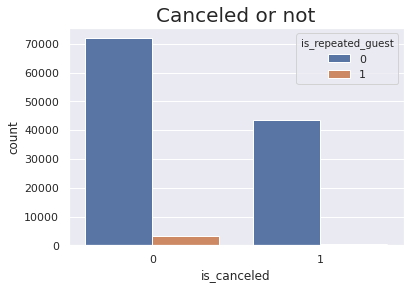

In [ ]:
sns.set(style = "darkgrid")
plt.title("Canceled or not", fontdict = {'fontsize': 20})
ax = sns.countplot(x = "is_canceled", hue = 'is_repeated_guest', data = data)

There is no surprise that repeated guests do not cancel their reservations. Of course there are some exceptions.
Also most of the customers are not repeated guests.

### Boxplot Distribution of Nights Spent at Hotels by Market Segment and Hotel Type 

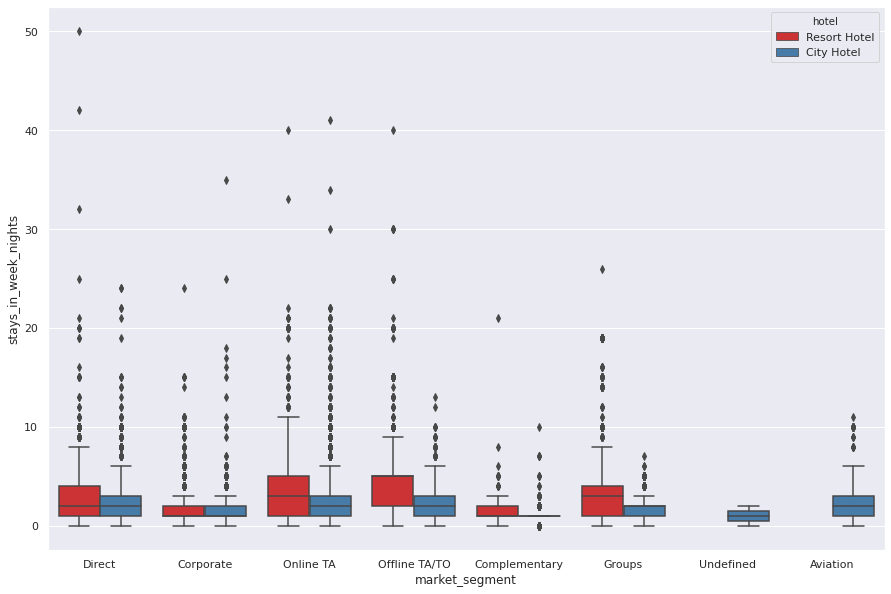

In [ ]:
plt.figure(figsize = (15,10))
sns.boxplot(x = "market_segment", y = "stays_in_week_nights", data = data, hue = "hotel", palette = 'Set1');

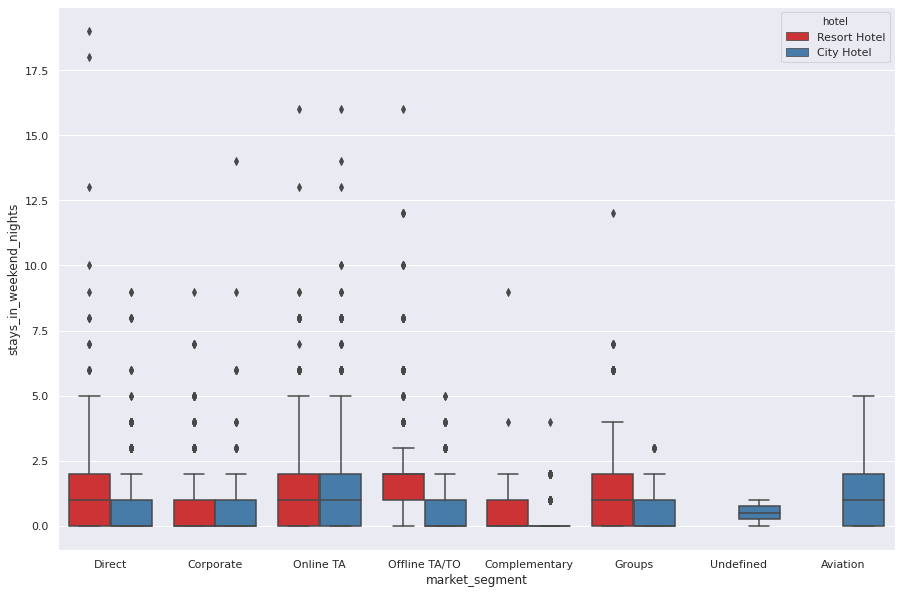

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x = "market_segment", y = "stays_in_weekend_nights", data = data, hue = "hotel", palette = 'Set1');

It can be seen that most of the groups are normal distributed, some of them have high skewness.
Looking at the distribution, most people do not seem to prefer to stay at the hotel for more than 1 week. But it seems normal to stay in resort hotels for up to 12-13 days. Although this changes according to the segments, staying longer than 15 days certainly creates outliers for each segment. If the total time feature was created by summing up the weekend and week nights, this would be clearer, but it can be clearly seen when looking at the two visualizations together.

As it turns out, customers from Aviation Segment do not seem to be staying at the resort hotels and have a relatively lower day average. Apart from that, the weekends and weekdays averages are roughly equal. Customers in the Aviation Segment are likely to arrive shortly due to business. Also probably most airports are a bit away from sea and its most likely to be closer to city hotels.

It is obvious that when people go to resort hotels, they prefer to stay more.

### Countplot Distribution of Market Segments

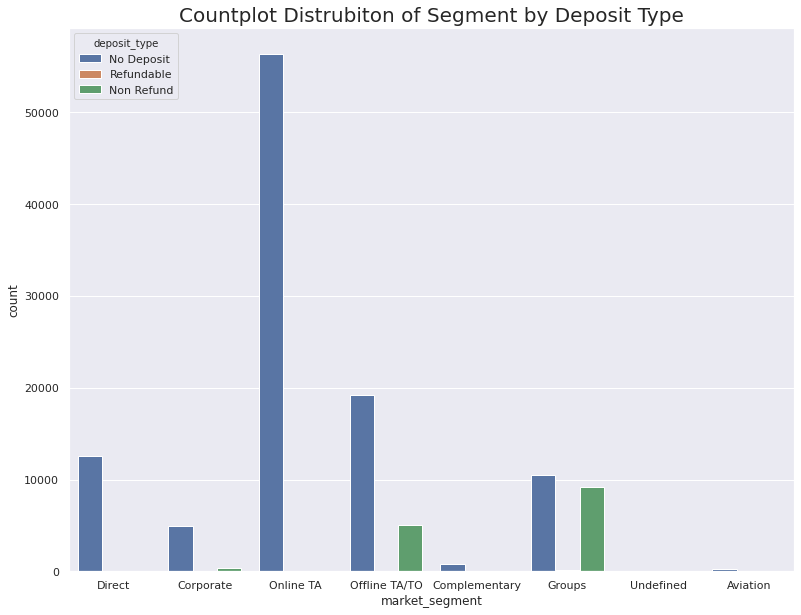

In [ ]:
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Countplot Distrubiton of Segment by Deposit Type", fontdict = {'fontsize':20})
ax = sns.countplot(x = "market_segment", hue = 'deposit_type', data = data)

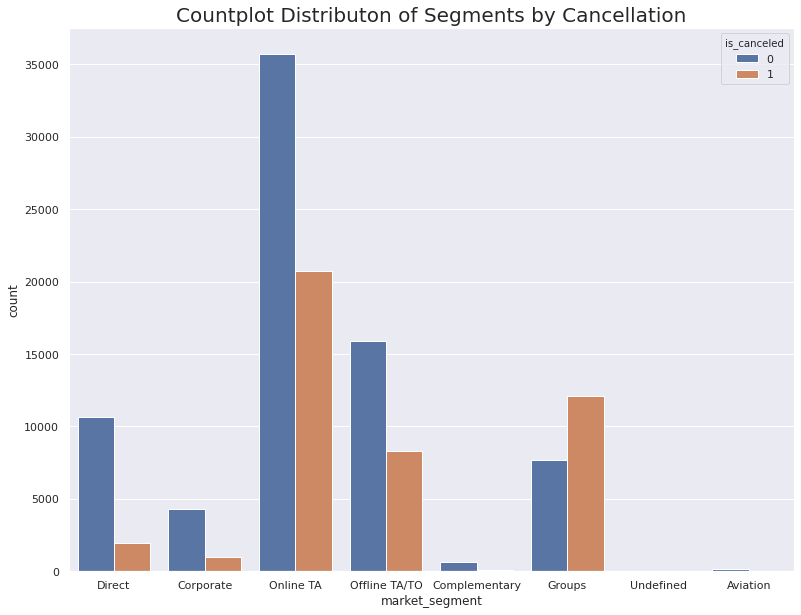

In [ ]:
plt.figure(figsize = (13,10))
sns.set(style = "darkgrid")
plt.title("Countplot Distributon of Segments by Cancellation", fontdict = {'fontsize':20})
ax = sns.countplot(x = "market_segment", hue = 'is_canceled', data = data)

Looking at Offline TA/TO and Groups, the situations where the deposit was received were only in the scenarios where the groups came. It is quite logical to apply a deposit for a large number of customers who will fill important amount of the hotel capacity.

As a first thought, I expected the cancellation rate in the market segments where a deposit is applied to be lower than the other segments where no deposit applied. But when we look at the cancellations according to the segments in the other visualization, it seems that this is not the case. 

- Groups segment has cancellation rate more than 50%.
- Offline TA/TO (Travel Agents/Tour Operators) and Online TA has cancellation rate more than 33%.
- Direct segment has cancellation rate less than 20%.

It is surprising that the cancellation rate in these segments is high despite the application of a deposit. The fact that cancellations are made collectively like reservations may explain this situation a bit.

Cancellation rates for online reservations are as expected in a dynamic environment where the circulation is high.

Another situation that took my attention is that the cancellation rate in the direct segment is so low. At this point, I think that a mutual trust relationship has been established in case people are communicating one to one. I will not dwell on this much, but I think there is a psychological factor here.

### Density Curve of Lead Time by Cancelation

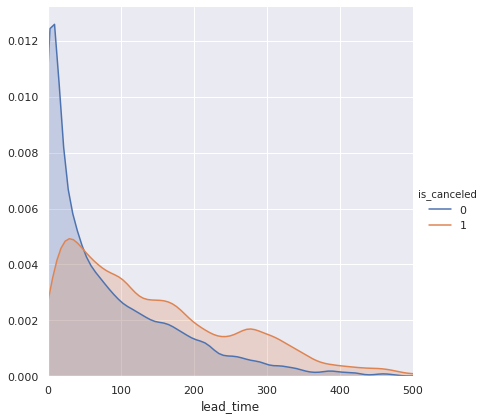

In [ ]:
(sns.FacetGrid(data, hue = 'is_canceled',
             height = 6,
             xlim = (0,500))
    .map(sns.kdeplot, 'lead_time', shade = True)
    .add_legend());

While lead time is more than roughly 60, people tend to cancel their reservations (cancellation rate is higher after this point). 
Also people want their holiday or work plans resulted in 100 days which equals to half of the data.

### Monthly Cancellations and Customers by Hotel Types

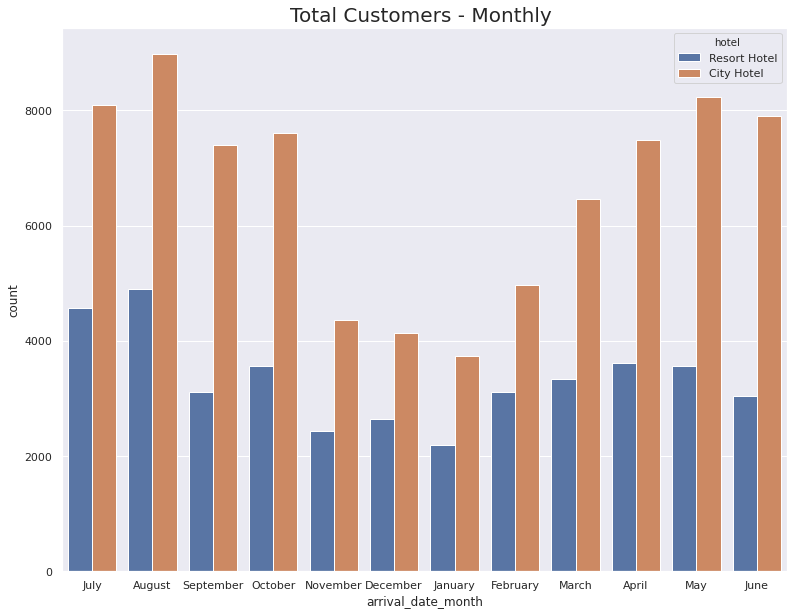

In [ ]:
plt.figure(figsize =(13,10))
sns.set(style="darkgrid")
plt.title("Total Customers - Monthly ", fontdict={'fontsize': 20})
ax = sns.countplot(x = "arrival_date_month", hue = 'hotel', data = data)

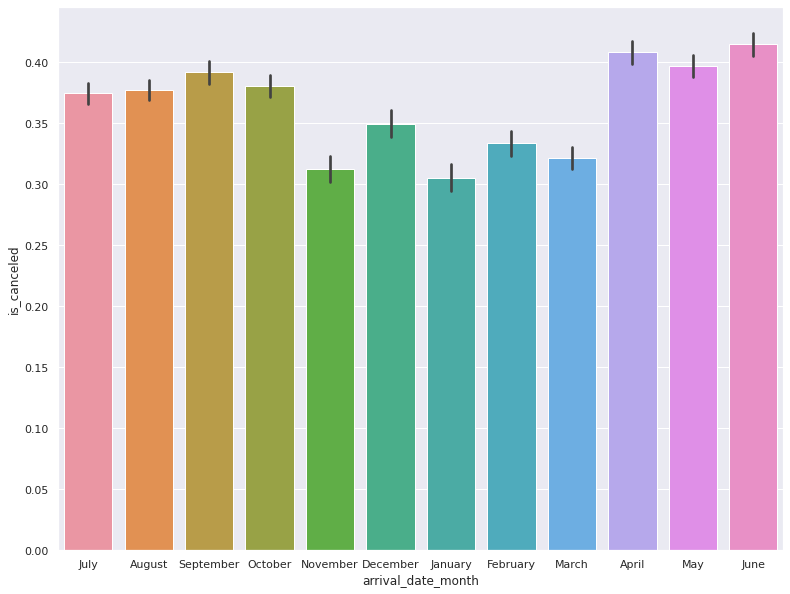

In [ ]:
plt.figure(figsize = (13,10))
sns.barplot(x = 'arrival_date_month', y = 'is_canceled', data = data);

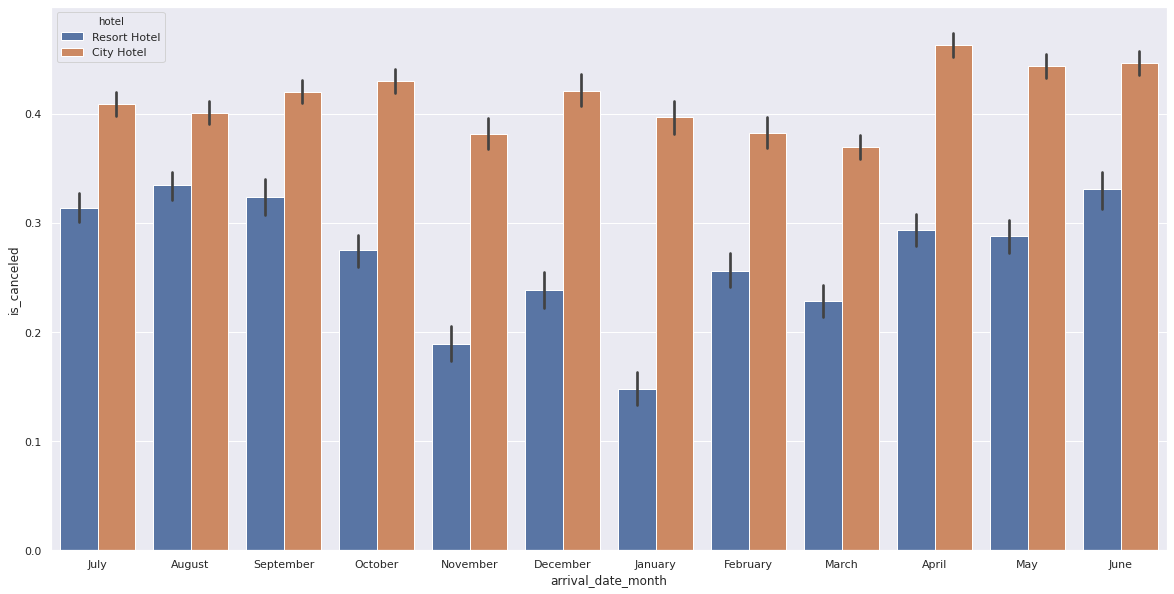

In [ ]:
plt.figure(figsize = (20,10))
sns.barplot(x = 'arrival_date_month', y = 'is_canceled', hue = 'hotel', data = data);

Looking at the first graph, it can be seen that the city hotels have more customers in all months. Considering proportionally, resort hotels seem to be a little closer to city hotels in summer.

An important interpretation can be made by examining three graphics together. Fewer customers come in the winter months, so when we look at the cancellation rates, it is quite normal that it appears less in the winter months. The point to be noted on these months is that the cancellation rates of city hotels are almost equal to other months even in winter. The fact that the total cancellation rates of the winter months are low is that the cancellation rates of the resort hotels are low in these months.
In short, the possibility of cancellation of resort hotels in winter is very low. This information can be a very important factor when predicting 'is_canceled'.

# Preprocessing 
### (Missing Values, Feature Engineering and Standardization)

In [ ]:
print("# of NaN in each columns:", df.isnull().sum(), sep='\n')

# of NaN in each columns:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                          

In [ ]:
def perc_mv(x, y):
    perc = y.isnull().sum() / len(x) * 100
    return perc

print('Missing value ratios:\nCompany: {}\nAgent: {}\nCountry: {}'.format(perc_mv(df, df['company']),
                                                                                   perc_mv(df, df['agent']),
                                                                                   perc_mv(df, df['country'])))

Missing value ratios:
Company: 94.30689337465449
Agent: 13.686238378423655
Country: 0.40874445095904177


In [ ]:
data["agent"].value_counts().count()

333

As we can see 94.3% of company column are missing values. Therefore we do not have enough values to fill the rows of company column by predicting, filling by mean etc. It seems that the best option is dropping company column.

13.68% of agent column are missing values, there is no need to drop agent column. But also we should not drop the rows because 13.68% of data is really huge amount and those rows have the chance to have crucial information. There are 333 unique agent, since there are too many agents they may not be predictable. 
Also NA values can be the agents that are not listed in present 333 agents. We can't predict agents and since missing values are 13% of all data we can't drop them too. I will decide what to do about agent after correlation section.

It will not be a problem if we drop the rows that have missing values in country column. Still, I will wait for correlation.

In [ ]:
# company is dropped
data = data.drop(['company'], axis = 1)

In [ ]:
# We have also 4 missing values in children column. If there is no information about children, In my opinion those customers do not have any children.
data['children'] = data['children'].fillna(0)

### Handling Features

We should check the features to create some more meaningful variables and reduce the number of features if it is possible.

In [ ]:
data.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [ ]:
# I wanted to label them manually. I will do the rest with get.dummies or label_encoder.
data['hotel'] = data['hotel'].map({'Resort Hotel':0, 'City Hotel':1})

data['arrival_date_month'] = data['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})

In [ ]:
def family(data):
    if ((data['adults'] > 0) & (data['children'] > 0)):
        val = 1
    elif ((data['adults'] > 0) & (data['babies'] > 0)):
        val = 1
    else:
        val = 0
    return val

def deposit(data):
    if ((data['deposit_type'] == 'No Deposit') | (data['deposit_type'] == 'Refundable')):
        return 0
    else:
        return 1

In [ ]:
def feature(data):
    data["is_family"] = data.apply(family, axis = 1)
    data["total_customer"] = data["adults"] + data["children"] + data["babies"]
    data["deposit_given"] = data.apply(deposit, axis=1)
    data["total_nights"] = data["stays_in_weekend_nights"]+ data["stays_in_week_nights"]
    return data

data = feature(data)

In [ ]:
# Information of these columns is also inside of new features, so it is better to drop them.
# I did not drop stays_nights features, I can't decide which feature is more important there.
data = data.drop(columns = ['adults', 'babies', 'children', 'deposit_type', 'reservation_status_date'])

After correlation we will decide what to do about country, agent and total_nights.

### Correlation

In [ ]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'is_family', 'total_customer', 'deposit_given',
       'total_nights'],
      dtype='object')

In [ ]:
# Lets copy data to check the correlation between variables. 
cor_data = data.copy()

In [ ]:
le = LabelEncoder()

In [ ]:
# This data will not be used while predicting cancellation. This is just for checking correlation.
cor_data['meal'] = le.fit_transform(cor_data['meal'])
cor_data['distribution_channel'] = le.fit_transform(cor_data['distribution_channel'])
cor_data['reserved_room_type'] = le.fit_transform(cor_data['reserved_room_type'])
cor_data['assigned_room_type'] = le.fit_transform(cor_data['assigned_room_type'])
cor_data['agent'] = le.fit_transform(cor_data['agent'])
cor_data['customer_type'] = le.fit_transform(cor_data['customer_type'])
cor_data['reservation_status'] = le.fit_transform(cor_data['reservation_status'])
cor_data['market_segment'] = le.fit_transform(cor_data['market_segment'])

In [ ]:
cor_data.corr()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,meal,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,is_family,total_customer,deposit_given,total_nights
hotel,1.000000,0.136531,0.075381,0.035267,0.001817,0.001270,-0.001862,-0.186596,-0.234020,0.008018,...,0.072432,0.047531,0.096719,-0.218873,-0.043390,-0.124331,-0.058306,-0.040821,0.172003,-0.247479
is_canceled,0.136531,1.000000,0.293123,0.016660,0.011022,0.008148,-0.006130,-0.001791,0.024765,-0.017678,...,0.054186,-0.068140,0.047557,-0.195498,-0.234658,-0.917196,-0.013010,0.046522,0.481457,0.017779
lead_time,0.075381,0.293123,1.000000,0.040142,0.131424,0.126871,0.002268,0.085671,0.165799,0.000349,...,0.170084,0.073403,-0.063077,-0.116451,-0.095712,-0.302175,-0.043972,0.072265,0.380179,0.157167
arrival_date_year,0.035267,0.016660,0.040142,1.000000,-0.527739,-0.540561,-0.000221,0.021497,0.030883,0.065840,...,-0.056497,-0.006149,0.197580,-0.013684,0.108531,-0.017683,0.052711,0.052127,-0.065963,0.031438
arrival_date_month,0.001817,0.011022,0.131424,-0.527739,1.000000,0.995105,-0.026063,0.018440,0.019212,-0.015205,...,0.019045,-0.029753,0.079315,0.000257,0.028026,-0.021090,0.010427,0.027252,0.008746,0.021536
arrival_date_week_number,0.001270,0.008148,0.126871,-0.540561,0.995105,1.000000,0.066809,0.018208,0.015558,-0.017381,...,0.022933,-0.028432,0.075791,0.001920,0.026149,-0.017387,0.010611,0.025220,0.007773,0.018719
arrival_date_day_of_month,-0.001862,-0.006130,0.002268,-0.000221,-0.026063,0.066809,1.000000,-0.016354,-0.028174,-0.007086,...,0.022728,0.012188,0.030245,0.008683,0.003062,0.011460,0.014710,0.006742,-0.008616,-0.027408
stays_in_weekend_nights,-0.186596,-0.001791,0.085671,0.021497,0.018440,0.018208,-0.016354,1.000000,0.498969,0.045744,...,-0.054151,-0.109220,0.049342,-0.018554,0.072671,0.008558,0.052306,0.101426,-0.114275,0.762790
stays_in_week_nights,-0.234020,0.024765,0.165799,0.030883,0.019212,0.015558,-0.028174,0.498969,1.000000,0.036742,...,-0.002020,-0.127223,0.065237,-0.024859,0.068192,-0.021607,0.050424,0.101665,-0.079999,0.941005
meal,0.008018,-0.017678,0.000349,0.065840,-0.015205,-0.017381,-0.007086,0.045744,0.036742,1.000000,...,-0.007132,0.044658,0.059098,-0.038923,0.023136,0.015393,-0.041727,-0.005975,-0.090725,0.045277


In [ ]:
cor_data.corr()["is_canceled"].sort_values()

reservation_status               -0.917196
total_of_special_requests        -0.234658
required_car_parking_spaces      -0.195498
assigned_room_type               -0.176028
booking_changes                  -0.144381
agent                            -0.127883
is_repeated_guest                -0.084793
customer_type                    -0.068140
reserved_room_type               -0.061282
previous_bookings_not_canceled   -0.057358
meal                             -0.017678
is_family                        -0.013010
arrival_date_day_of_month        -0.006130
stays_in_weekend_nights          -0.001791
arrival_date_week_number          0.008148
arrival_date_month                0.011022
arrival_date_year                 0.016660
total_nights                      0.017779
stays_in_week_nights              0.024765
total_customer                    0.046522
adr                               0.047557
days_in_waiting_list              0.054186
market_segment                    0.059338
previous_ca

As we can see in the sorted list, reservation_status seems to be most impactful feature. With that information accuracy rate should be really high. It can be better to drop reservation_status column to see how other features can predict. I am going to try both.

Impacts of three feature that are created:
- deposit_given = 0,48131
- is_family = -0,01327
- total_customer = 0,04504

Apart from that, I will not use arrival_date_week_number, stays_in_weekend_nights and arrival_date_day_of_month since their importances are really low while predicting cancellations. 

Also, still we have some missing values in agent column. It has nice importance on predicting cancellation but since the missing values are equal to 13% of the total data it is better to drop that column. It has a lot of class inside of it otherwise we could try predicting missing values but they may misguide the predictions.

In [ ]:
# It is highly correlated to total_nights and also there is no much difference impact, so I will not use total_nights.
# Week nights have higher impact.
"""
Actually, I tried some models by using different features as (only total_nights | weekend_nights and week_nights | only week_nights ...) 
and the models using only week nights seems to have a bit higher accuracy score. 
"""

cor_data.corr()['stays_in_week_nights']

hotel                            -0.234020
is_canceled                       0.024765
lead_time                         0.165799
arrival_date_year                 0.030883
arrival_date_month                0.019212
arrival_date_week_number          0.015558
arrival_date_day_of_month        -0.028174
stays_in_weekend_nights           0.498969
stays_in_week_nights              1.000000
meal                              0.036742
market_segment                    0.108569
distribution_channel              0.087185
is_repeated_guest                -0.097245
previous_cancellations           -0.013992
previous_bookings_not_canceled   -0.048743
reserved_room_type                0.168616
assigned_room_type                0.100795
booking_changes                   0.096209
agent                            -0.110354
days_in_waiting_list             -0.002020
customer_type                    -0.127223
adr                               0.065237
required_car_parking_spaces      -0.024859
total_of_sp

In [ ]:
cor_data = cor_data.drop(columns = ['total_nights', 'arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'agent'], axis = 1)

In [ ]:
#Lets delete the NA rows of country column
indices = cor_data.loc[pd.isna(cor_data["country"]), :].index 
cor_data = cor_data.drop(cor_data.index[indices])   
cor_data.isnull().sum()

#There is no missing value in the data

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_day_of_month         0
stays_in_week_nights              0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
is_family                         0
total_customer                    0
deposit_given                     0
dtype: int64

**Since we have decided what to do with features and missing values, we can work on first data.**

In [ ]:
indices = data.loc[pd.isna(data["country"]), :].index 
data = data.drop(data.index[indices])   
data = data.drop(columns = ['arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'agent'], axis = 1)

In [ ]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_day_of_month', 'stays_in_week_nights', 'meal', 'country',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'is_family', 'total_customer', 'deposit_given',
       'total_nights'],
      dtype='object')

In [ ]:
# I keep data in case of any changes on features, missing values etc.
df1 = data.copy()

In [ ]:
#one-hot-encoding
df1 = pd.get_dummies(data = df1, columns = ['meal', 'market_segment', 'distribution_channel',
                                            'reserved_room_type', 'assigned_room_type', 'customer_type', 'reservation_status'])

In [ ]:
df1['country'] = le.fit_transform(df1['country']) 
# There are more than 300 classes, so I wanted to use label encoder on this feature.

### Decision Tree Model (reservation_status included)

In [ ]:
y = df1["is_canceled"]
X = df1.drop(["is_canceled"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
cart = DecisionTreeClassifier(max_depth = 12)

In [ ]:
cart_model = cart.fit(X_train, y_train)

In [ ]:
y_pred = cart_model.predict(X_test)

In [ ]:
print('Decision Tree Model')

print('Accuracy Score: {}\n\nConfusion Matrix:\n {}\n\nAUC Score: {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred), roc_auc_score(y_test,y_pred)))

Decision Tree Model
Accuracy Score: 1.0

Confusion Matrix:
 [[22353     0]
 [    0 13318]]

AUC Score: 1.0


Text(0.5, 0, 'Feature Importances (%)')

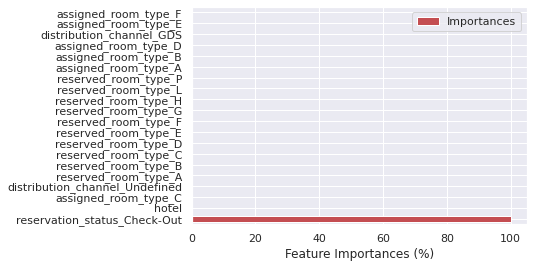

In [ ]:
pd.DataFrame(data = cart_model.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False)[:20].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")

In the correlation part, we have seen the impact of reservation status. Reservation status dominates other features totally. By keeping reservation_status in data, it is possible to achieve 100% accuracy rate because that feature is direct way to predict cancellations, its like cheating. For the sake of analysis I will drop reservation_status and continue analysis without it.

### Final Arrangements Before Comparing the Models

In [ ]:
df2 = df1.drop(columns = ['reservation_status_Canceled', 'reservation_status_Check-Out', 'reservation_status_No-Show'], axis = 1)

In [ ]:
y = df2["is_canceled"]
X = df2.drop(["is_canceled"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [ ]:
# We can use the functions to apply the models and roc curves to save space.
def model(algorithm, X_train, X_test, y_train, y_test):
    alg = algorithm
    alg_model = alg.fit(X_train, y_train)
    global y_prob, y_pred
    y_prob = alg.predict_proba(X_test)[:,1]
    y_pred = alg_model.predict(X_test)

    print('Accuracy Score: {}\n\nConfusion Matrix:\n {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred)))
    

def ROC(y_test, y_prob):
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

# Model and ROC Curve Comparison

### Logistic Regression Model

In [ ]:
print('Model: Logistic Regression\n')
model(LogisticRegression(solver = "liblinear"), X_train, X_test, y_train, y_test)

Model: Logistic Regression

Accuracy Score: 0.8041266014409464

Confusion Matrix:
 [[20476  1877]
 [ 5110  8208]]


In [ ]:
LogR = LogisticRegression(solver = "liblinear")
cv_scores = cross_val_score(LogR, X, y, cv = 8, scoring = 'accuracy')
print('Mean Score of CV: ', cv_scores.mean())

Mean Score of CV:  0.7692639068322691


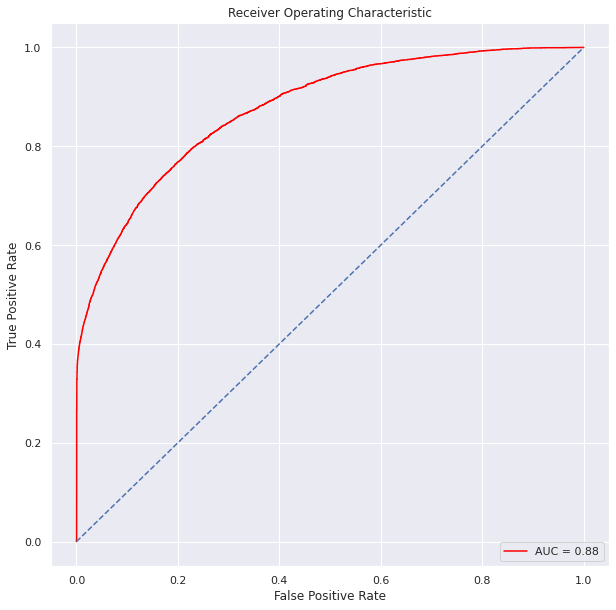

In [ ]:
ROC(y_test, y_prob)

### Gaussian Naive Bayes Model

In [ ]:
print('Model: Gaussian Naive Bayes\n')
model(GaussianNB(), X_train, X_test, y_train, y_test)

Model: Gaussian Naive Bayes

Accuracy Score: 0.586246530795324

Confusion Matrix:
 [[ 9604 12749]
 [ 2010 11308]]


In [ ]:
NB = GaussianNB()
cv_scores = cross_val_score(NB, X, y, cv = 8, scoring = 'accuracy')
print('Mean Score of CV: ', cv_scores.mean())

Mean Score of CV:  0.5624280984012298


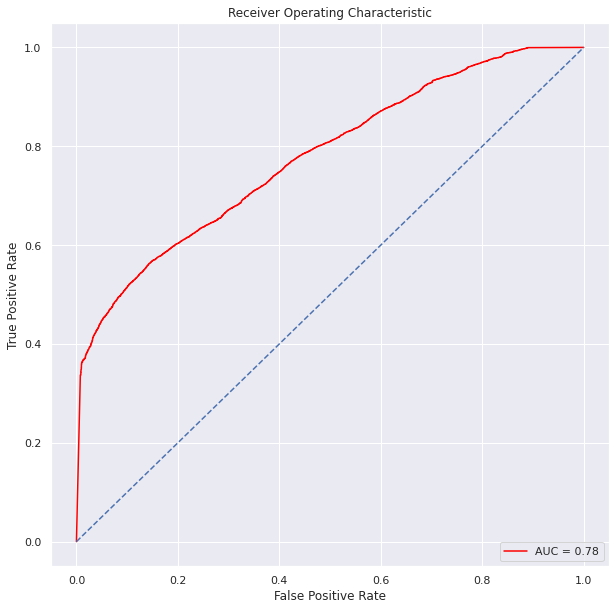

In [ ]:
ROC(y_test, y_prob)

### Support Vector Classification Model

In [ ]:
#I excluded probability in the function for SVC, also I could not use other kernel methods because it takes really long and I don't think SVC as a good model for this dateset. 
print('Model: SVC\n')

def model1(algorithm, X_train, X_test, y_train, y_test):
    alg = algorithm
    alg_model = alg.fit(X_train, y_train)
    global y_pred
    y_pred = alg_model.predict(X_test)
    
    print('Accuracy Score: {}\n\nConfusion Matrix:\n {}'
      .format(accuracy_score(y_test,y_pred), confusion_matrix(y_test,y_pred)))
    
model1(SVC(kernel = 'linear'), X_train, X_test, y_train, y_test)

Model: SVC

Accuracy Score: 0.7942586414734658

Confusion Matrix:
 [[20864  1489]
 [ 5850  7468]]


### Decision Tree Model (reservation_status excluded)

In [ ]:
print('Model: Decision Tree\n')
model(DecisionTreeClassifier(max_depth = 12), X_train, X_test, y_train, y_test)

Model: Decision Tree

Accuracy Score: 0.8464579069832637

Confusion Matrix:
 [[20379  1974]
 [ 3503  9815]]


In [ ]:
DTC = DecisionTreeClassifier(max_depth = 12)
cv_scores = cross_val_score(DTC, X, y, cv = 8, scoring = 'accuracy')
print('Mean Score of CV: ', cv_scores.mean())

Mean Score of CV:  0.6725617115938002


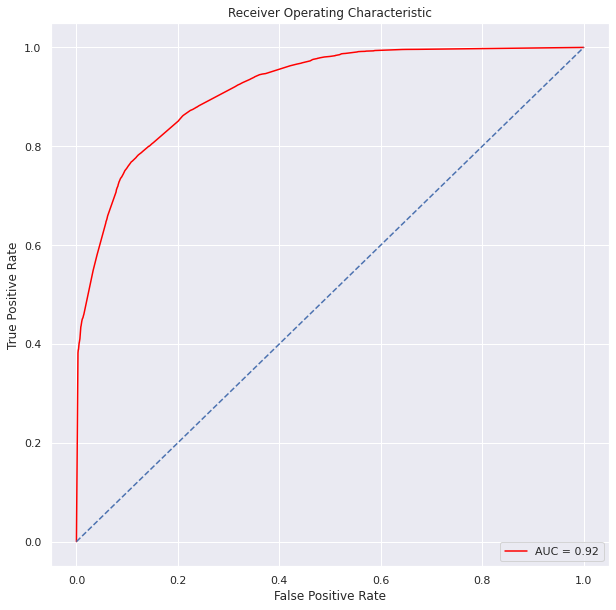

In [ ]:
ROC(y_test, y_prob)

### Random Forest

In [ ]:
print('Model: Random Forest\n')
model(RandomForestClassifier(), X_train, X_test, y_train, y_test)

Model: Random Forest

Accuracy Score: 0.8835748927700373

Confusion Matrix:
 [[20946  1407]
 [ 2746 10572]]


In [ ]:
RFC = RandomForestClassifier()
cv_scores = cross_val_score(RFC, X, y, cv = 8, scoring = 'accuracy')
print('Mean Score of CV: ', cv_scores.mean())

Mean Score of CV:  0.6697106885103477


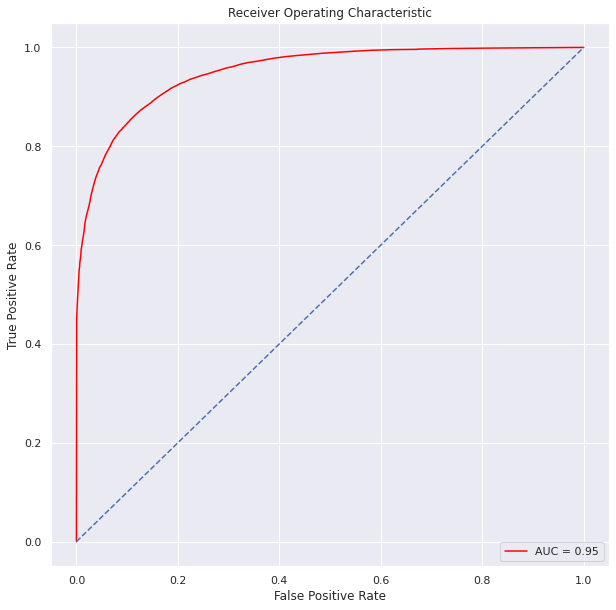

In [ ]:
ROC(y_test, y_prob)

### Random Forest Model Tuning

In [ ]:
rf_parameters = {"max_depth": [10,13],
                 "n_estimators": [10,100,500],
                 "min_samples_split": [2,5]}

In [ ]:
rf_model = RandomForestClassifier()

In [ ]:
rf_cv_model = GridSearchCV(rf_model,
                           rf_parameters,
                           cv = 10,
                           n_jobs = -1,
                           verbose = 2)

rf_cv_model.fit(X_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 12.5min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [ ]:
print('Best parameters: ' + str(rf_cv_model.best_params_))

Best parameters: {'max_depth': 13, 'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
rf_tuned = RandomForestClassifier(max_depth = 13,
                                  min_samples_split = 2,
                                  n_estimators = 500)

print('Model: Random Forest Tuned\n')
model(rf_tuned, X_train, X_test, y_train, y_test)

Model: Random Forest Tuned

Accuracy Score: 0.8515320568529057

Confusion Matrix:
 [[21151  1202]
 [ 4094  9224]]


Tuned model has worse accuracy score than default one. In the default model there is no limit for max depth. Increasing max depth gives us better accuracy scores but may decrease generalization.

### XGBoost Model

In [ ]:
print('Model: XGBoost\n')
model(XGBClassifier(), X_train, X_test, y_train, y_test)

Model: XGBoost

Accuracy Score: 0.8696980740657677

Confusion Matrix:
 [[20570  1783]
 [ 2865 10453]]


In [ ]:
XGB = XGBClassifier()
cv_scores = cross_val_score(XGB, X, y, cv = 8, scoring = 'accuracy')
print('Mean Score of CV: ', cv_scores.mean())

Mean Score of CV:  0.651031688035794


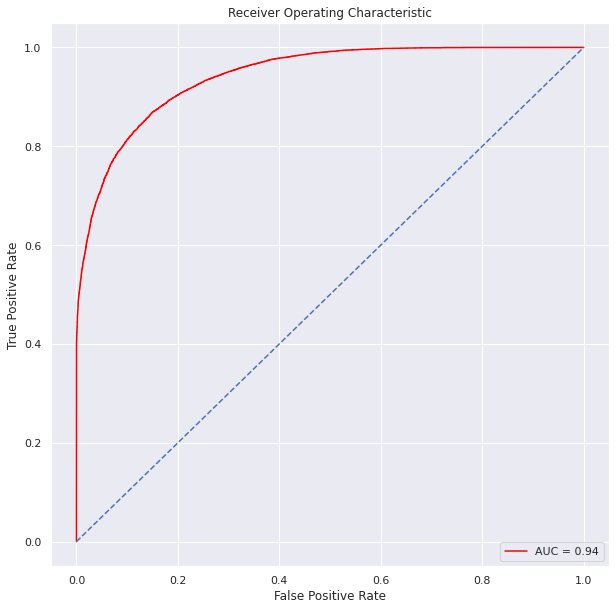

In [ ]:
ROC(y_test, y_prob)

### Neural Network Model

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
print('Model: Neural Network\n')
model(MLPClassifier(), X_train_scaled, X_test_scaled, y_train, y_test)

Model: Neural Network

Accuracy Score: 0.8486445572033304

Confusion Matrix:
 [[20212  2141]
 [ 3258 10060]]


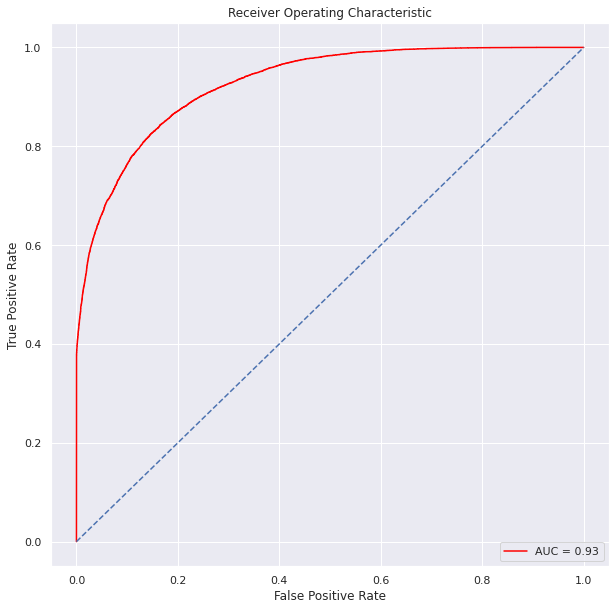

In [ ]:
ROC(y_test, y_prob)

### Neural Network Model Tuning

In [ ]:
mlpc_parameters = {"alpha": [1, 0.1, 0.01, 0.001],
                   "hidden_layer_sizes": [(50,50,50),
                                          (100,100)],
                   "solver": ["adam", "sgd"],
                   "activation": ["logistic", "relu"]}

In [ ]:
mlpc = MLPClassifier()
mlpc_cv_model = GridSearchCV(mlpc, mlpc_parameters,
                             cv = 10,
                             n_jobs = -1,
                             verbose = 2)

mlpc_cv_model.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 123.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 290.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={

In [ ]:
print('Best parameters: ' + str(mlpc_cv_model.best_params_))

Best parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 100), 'solver': 'adam'}


In [ ]:
mlpc_tuned = MLPClassifier(activation = 'relu',
                           alpha = 0.1,
                           hidden_layer_sizes = (100,100),
                           solver = 'adam')

In [ ]:
print('Model: Neural Network Tuned\n')
model(mlpc_tuned, X_train_scaled, X_test_scaled, y_train, y_test)

Model: Neural Network Tuned

Accuracy Score: 0.859409604440582

Confusion Matrix:
 [[20464  1889]
 [ 3126 10192]]


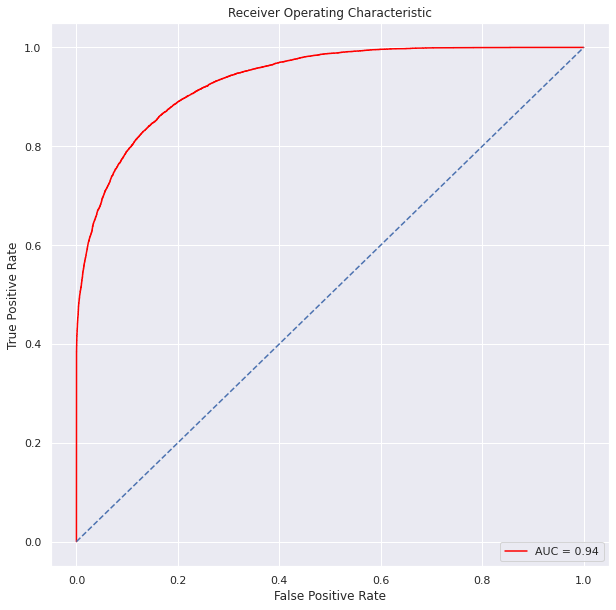

In [ ]:
ROC(y_test, y_prob)

# Conclusion

### Feature Importances

Text(0.5, 0, 'Feature Importances (%)')

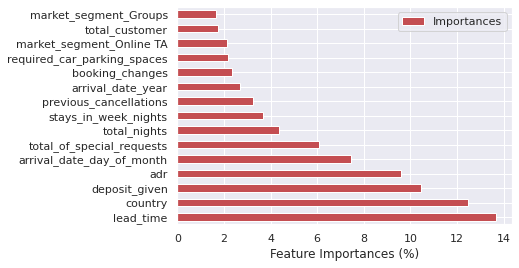

In [ ]:
randomf = RandomForestClassifier()
rf_model1 = randomf.fit(X_train, y_train)

pd.DataFrame(data = rf_model1.feature_importances_*100,
                   columns = ["Importances"],
                   index = X_train.columns).sort_values("Importances", ascending = False)[:15].plot(kind = "barh", color = "r")

plt.xlabel("Feature Importances (%)")

### Summary Table of the Models

In [ ]:
table = pd.DataFrame({"Model": ["Decision Tree (reservation status included)", "Logistic Regression",
                                "Naive Bayes", "Support Vector", "Decision Tree", "Random Forest",
                                "Random Forest Tuned", "XGBoost", "Neural Network", "Neural Network Tuned"],
                     "Accuracy Scores": ["1", "0.804", "0.582", "0.794", "0.846",
                                         "0.883", "0.851", "0.869", "0.848", "0.859"],
                     "ROC | Auc": ["1", "0.88", "0.78", "0",
                                   "0.92", "0.95", "0", "0.94",
                                   "0.93", "0.94"]})


table["Model"] = table["Model"].astype("category")
table["Accuracy Scores"] = table["Accuracy Scores"].astype("float32")
table["ROC | Auc"] = table["ROC | Auc"].astype("float32")

pd.pivot_table(table, index = ["Model"]).sort_values(by = 'Accuracy Scores', ascending=False)

,Accuracy Scores,ROC | Auc
Model,,
Decision Tree (reservation status included),1.000,1.00
Random Forest,0.883,0.95
XGBoost,0.869,0.94
Neural Network Tuned,0.859,0.94
Random Forest Tuned,0.851,0.00
Neural Network,0.848,0.93
Decision Tree,0.846,0.92
Logistic Regression,0.804,0.88
Support Vector,0.794,0.00


- As we can see from the summary table, the best algorithm is random forest for this data set. 
- 0 values are uncalculated ones.
- We do not count decision tree with reservatiton status which is broken. All algorithms would give 100% accuracy scores while reservation status is included.
- Tuning for XGBoost would be a good challenge too.

### Thanks for reading all of my analysis. If you have questions, do not hesitate to ask!
### I am open to all the feedbacks. 